# Testing the objective function
1. Test if max enb (closed form) is the same as equalizing the factor risk contribution


In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from scipy.linalg import svd
import itertools
from scipy.optimize import minimize
import time
import cvxpy as cp

raw = pd.read_pickle('etf_er.pkl')
sample = raw.iloc[:, :5].dropna()
scaler = preprocessing.StandardScaler().fit(sample)
sample_z = scaler.transform(sample)

D = np.diag(np.sqrt(scaler.var_))
U, s, Vt = svd(
    sample_z,
    full_matrices=False,
    compute_uv=True,
    lapack_driver='gesdd'
)
S = np.diag(s)
V = Vt.T

combinations = [np.reshape(np.array(i), (S.shape[0], 1)) for i in itertools.product([1, -1], repeat=S.shape[0])]
J = np.concatenate(combinations, axis=1)
W = np.linalg.inv(D) @ V @ np.linalg.inv(S) @ J
W = np.divide(W, W.sum(axis=0))
W

array([[-3.65948250e-01, -2.20936538e+00,  4.39072779e+00,
         6.02789032e-01, -3.32197699e-01, -9.92025878e-01,
         8.23121730e-01, -2.95584347e-03, -2.36301805e+00,
        -8.72173224e+00, -1.32384424e+01,  1.01908734e+01,
        -7.41574816e-02, -1.05626001e+00,  1.69810423e+00,
         3.52983487e-01,  3.52983487e-01,  1.69810423e+00,
        -1.05626001e+00, -7.41574816e-02,  1.01908734e+01,
        -1.32384424e+01, -8.72173224e+00, -2.36301805e+00,
        -2.95584347e-03,  8.23121730e-01, -9.92025878e-01,
        -3.32197699e-01,  6.02789032e-01,  4.39072779e+00,
        -2.20936538e+00, -3.65948250e-01],
       [-1.72872035e-01, -1.68539043e+00, -1.76161790e+00,
        -2.73647228e+00,  1.87922146e+00,  1.07221311e+00,
         1.53636808e+00,  7.60577697e-01,  7.04892740e+00,
        -1.69612425e+01,  9.34572385e+00, -3.11544202e+01,
         2.05628232e+00,  8.80848831e-01,  1.53842056e+00,
         4.31371854e-01,  4.31371854e-01,  1.53842056e+00,
         8.80

In [3]:
def effective_bets(weights, singular_values_matrix, eigen_vector_matrix, vol, k=None):
    w = weights.reshape(-1, 1)
    eigen_wts = eigen_vector_matrix.T @ np.diag(vol) @ w
    p = (np.diag(eigen_wts.flatten()) @ singular_values_matrix.T @ singular_values_matrix @ eigen_wts).flatten()
    if k is not None:
        p = p[:k]
    p_norm = np.divide(p, p.sum())
    eta = np.exp(-np.sum(np.multiply(p_norm, np.log(p_norm))))
    return eta


def objective_diversify(weights, singular_values_matrix, eigen_vector_matrix, vol, k=None):
    enb = effective_bets(weights, singular_values_matrix, eigen_vector_matrix, vol, k)
    return -enb

cons = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
)

opti = minimize(
    fun=objective_diversify,
    x0=np.array([1 / sample.shape[1]] * sample.shape[1]),
    args=(S, V, np.diag(D)),
    constraints=cons,
    method='SLSQP',
    options={'maxiter': 1E9, 'ftol': 1E-12}
)

print(opti.x)
effective_bets(opti.x, S, V, np.diag(D))

[ -8.72174785 -16.96127116   7.62754448  12.7998851    6.25558943]


4.999999999999638

Which is one of the sets in the closed form solution

In [4]:
for j in range(J.shape[1]):
    V2 = V @ np.diag(J[:, j])
    opti = minimize(
        fun=objective_diversify,
        x0=np.array([1] * sample.shape[1]),
        args=(S, V2, np.diag(D)),
        constraints=cons,
        method='SLSQP',
        options={'maxiter': 1E9, 'ftol': 1E-12}
    )

    print(opti.x)
    effective_bets(opti.x, S, V, np.diag(D))

[ -8.72171236 -16.96120432   7.62751998  12.79983135   6.25556534]
[ -8.72171236 -16.96120432   7.62751998  12.79983135   6.25556534]
[ -8.72171236 -16.96120432   7.62751998  12.79983135   6.25556534]
[ -8.72171236 -16.96120432   7.62751998  12.79983135   6.25556534]
[ -8.72171236 -16.96120432   7.62751998  12.79983135   6.25556534]
[ -8.72171236 -16.96120432   7.62751998  12.79983135   6.25556534]
[ -8.72171236 -16.96120432   7.62751998  12.79983135   6.25556534]
[ -8.72171236 -16.96120432   7.62751998  12.79983135   6.25556534]
[ -8.72171236 -16.96120432   7.62751998  12.79983135   6.25556534]
[ -8.72171236 -16.96120432   7.62751998  12.79983135   6.25556534]
[ -8.72171236 -16.96120432   7.62751998  12.79983135   6.25556534]
[ -8.72171236 -16.96120432   7.62751998  12.79983135   6.25556534]
[ -8.72171236 -16.96120432   7.62751998  12.79983135   6.25556534]
[ -8.72171236 -16.96120432   7.62751998  12.79983135   6.25556534]
[ -8.72171236 -16.96120432   7.62751998  12.79983135   6.25556

Despite we are changing the signs of the eigenvectors, I get the same answer always

In [5]:
def frc(weights, singular_values_matrix, eigen_vector_matrix, vol):
    w = weights.reshape(-1, 1)
    eigen_wts = eigen_vector_matrix.T @ np.diag(vol) @ w
    p = (np.diag(eigen_wts.flatten()) @ singular_values_matrix.T @ singular_values_matrix @ eigen_wts).flatten()
    return p

def objfunc(weights, singular_values_matrix, eigen_vector_matrix, vol):
    x = frc(weights, singular_values_matrix, eigen_vector_matrix, vol).reshape(-1, 1)
    c = np.ones(shape=(len(weights), 1))
    of = (x - c).T @ (x - c)
    return of.item()


opti = minimize(
    fun=objfunc,
    x0=np.array([1 / sample.shape[1]] * sample.shape[1]),
    args=(S, V, np.diag(D)),
    # constraints=cons,
    method='SLSQP',
    options={'maxiter': 1E9, 'ftol': 1E-12}
)

w = np.divide(opti.x, np.sum(opti.x))
print(w)
effective_bets(w, S, V, np.diag(D))

[ -8.72173151 -16.96124079   7.62753173  12.79986045   6.25558012]


4.999999999999998

After rescaling the weights, we get the same results, which means this could have a convex programming form.

Trying to simplify the objective function now, so it can be passed easily in an optimization problem.

In [6]:
def objfunc2(weights, singular_values_matrix, eigen_vector_matrix, vol):
    w = weights.reshape(-1, 1)
    x = singular_values_matrix @ eigen_vector_matrix.T @ np.diag(vol) @ w
    c = np.ones(shape=(len(weights), 1))
    of = (x - c).T @ (x - c)
    return of.item()


opti = minimize(
    fun=objfunc2,
    x0=np.array([1 / sample.shape[1]] * sample.shape[1]),
    args=(S, V, np.diag(D)),
    # constraints=cons,
    method='SLSQP',
    options={'maxiter': 1E9, 'ftol': 1E-12}
)

w = np.divide(opti.x, np.sum(opti.x))
print(w)
effective_bets(w, S, V, np.diag(D))

[-0.36594832 -0.17287213 -2.46741443 -1.28640077  5.29263565]


4.999999999999997

Which is another result in the closed form solutions set.

### Simplified Objective Function

\begin{align}
\arg \min_{w} \frac{1}{2} || \theta - c ||_{2}
\end{align}

where
\begin{align}
\theta = S V D w
\end{align}

finally getting

\begin{align}
\arg \min_{w} \frac{1}{2} w^{T} D V S^{T} S V^{T} D w - 1^{T} S V^{T} D w
\end{align}

Which is equivalent to minimizing the variance of the portfolio with a regularization component that depends on the projection of the asset weights into eigen-space.

In [7]:
def objfunc3(weights, singular_values_matrix, eigen_vector_matrix, vol):
    S = singular_values_matrix
    D = np.diag(vol)
    V = eigen_vector_matrix
    w = weights.reshape(-1, 1)
    of = 1 / 2 * w.T @ D.T @ V @ S.T @ S @ V.T @ D @ w - np.ones((1, len(weights))) @ S @ V.T @ D @ w

    return of.item()

tic = time.perf_counter()
opti = minimize(
    fun=objfunc3,
    x0=np.array([1 / sample.shape[1]] * sample.shape[1]),
    args=(S, V, np.diag(D)),
    # constraints=cons,
    method='SLSQP',
    options={'maxiter': 1E9, 'ftol': 1E-12}
)
toc = time.perf_counter()
print(f"Iteration finished in {(toc - tic):0.6f} seconds")
w = np.divide(opti.x, np.sum(opti.x))
print(w)
effective_bets(w, S, V, np.diag(D))

Iteration finished in 0.010656 seconds
[-0.36594825 -0.17287186 -2.46741427 -1.28640069  5.29263507]


4.999999999999995

### Quadratic Form
https://scaron.info/blog/conversion-from-least-squares-to-quadratic-programming.html
https://web.stanford.edu/~boyd/cvxbook/
https://stats.stackexchange.com/questions/490876/ridge-and-quadratic-programming-for-portfolio-norm-optimization
http://faculty.london.edu/avmiguel/DeMiguelGarlappiNogalesUppalMS.pdf
https://math.stackexchange.com/questions/4370875/closed-form-solution-for-quadratic-optimization-with-l2-regularization
https://davidrosenberg.github.io/ml2015/docs/2b.L1L2-regularization.pdf
https://dilequante.com/portfolio-optimization-minimize-risk-with-turnover-constraint-via-quadratic-programming/

\begin{align}
\arg \min_{w} \frac{1}{2} w^{T} D V S^{T} S V^{T} D w - 1^{T} S V^{T} D w
\end{align}

As a special case when Q is symmetric positive-definite, the cost function reduces to least squares:

\begin{align}
\arg \min_{w} \frac{1}{2} w^{T} P w + q^{T} w
\end{align}

where
\begin{align}
P &= D V S^{T} S V^{T} D \\
q &= - D V S 1
\end{align}




In [8]:
n = V.shape[0]
P = D.T @ V @ S.T @ S @ V.T @ D
q = - (np.ones((1, n)) @ S @ V.T @ D).T

tic = time.perf_counter()
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize((1/2) * cp.quad_form(x, P) + q.T @ x))
prob.solve()
toc = time.perf_counter()
print(f"Iteration finished in {(toc - tic):0.6f} seconds")
w = np.divide(x.value.flatten(), np.sum(x.value))
print(w)
effective_bets(x.value.flatten(), S, V, np.diag(D))

Iteration finished in 0.018358 seconds
[-0.36594825 -0.17287203 -2.46741453 -1.28640078  5.29263559]


5.000000000000001

### Incorporating constraints

In [9]:
# Minimize
cons = ({'type': 'ineq', 'fun': lambda x: x})

tic = time.perf_counter()
opti = minimize(
    fun=objfunc3,
    x0=np.array([1 / sample.shape[1]] * sample.shape[1]),
    args=(S, V, np.diag(D)),
    constraints=cons,
    method='SLSQP',
    options={'maxiter': 1E9, 'ftol': 1E-12}
)
toc = time.perf_counter()
print(f"Minimize finished in {(toc - tic):0.6f} seconds")
w = np.divide(opti.x, np.sum(opti.x))
print(np.round(w, 2))
print('ENB:', np.round(effective_bets(w, S, V, np.diag(D)), 4))

# QP
n = V.shape[0]
P = D.T @ V @ S.T @ S @ V.T @ D
q = - (np.ones((1, n)) @ S @ V.T @ D).T
G = - np.eye(n)
h = np.zeros(n)

tic = time.perf_counter()
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize((1/2) * cp.quad_form(x, P) + q.T @ x), [G @ x <= h])
prob.solve()
toc = time.perf_counter()
print(f"QP finished in {(toc - tic):0.6f} seconds")
w = np.divide(x.value.flatten(), np.sum(x.value))
print(np.round(w, 2))
print('ENB:', np.round(effective_bets(x.value.flatten(), S, V, np.diag(D)), 4))

Minimize finished in 0.008364 seconds
[ 0.  0.  0. -0.  1.]
ENB: 2.2601
QP finished in 0.012822 seconds
[-0.  0. -0. -0.  1.]
ENB: 2.2601


### With regularization
https://stats.stackexchange.com/questions/490876/ridge-and-quadratic-programming-for-portfolio-norm-optimization

\begin{align}
\arg \min_{w} \frac{1}{2} w^{T} (P + 2 \lambda I) w + q^{T} w
\end{align}

where
\begin{align}
P &= D V S^{T} S V^{T} D \\
q &= - D V S 1
\end{align}

Also calculate the jacobian of this problem
https://math.stackexchange.com/questions/4370875/closed-form-solution-for-quadratic-optimization-with-l2-regularization

In [10]:
# Minimize
def objfunc4(weights, singular_values_matrix, eigen_vector_matrix, vol, lmb=0):
    S = singular_values_matrix
    D = np.diag(vol)
    V = eigen_vector_matrix
    w = weights.reshape(-1, 1)
    of = 1 / 2 * w.T @ D.T @ V @ S.T @ S @ V.T @ D @ w - np.ones((1, len(weights))) @ S @ V.T @ D @ w + lmb * w.T @ w

    return of.item()

cons = ({'type': 'ineq', 'fun': lambda x: x})

tic = time.perf_counter()
opti = minimize(
    fun=objfunc4,
    x0=np.array([1 / sample.shape[1]] * sample.shape[1]),
    args=(S, V, np.diag(D), 1),
    constraints=cons,
    method='SLSQP',
    options={'maxiter': 1E9, 'ftol': 1E-12}
)
toc = time.perf_counter()
print(f"Minimize finished in {(toc - tic):0.6f} seconds")
w = np.divide(opti.x, np.sum(opti.x))
print(np.round(w, 2))
print('ENB (SLSQP):', np.round(effective_bets(w, S, V, np.diag(D)), 2))

# QP
lmb = 1
n = V.shape[0]
P = D.T @ V @ S.T @ S @ V.T @ D
Pr = P + 2 * lmb * np.eye(n)
q = - (np.ones((1, n)) @ S @ V.T @ D).T
G = - np.eye(n)
h = np.zeros(n)

tic = time.perf_counter()
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize((1/2) * cp.quad_form(x, Pr) + q.T @ x), [G @ x <= h])
prob.solve()
toc = time.perf_counter()
print(f"QP finished in {(toc - tic):0.6f} seconds")
w = np.divide(x.value.flatten(), np.sum(x.value))
print(np.round(w, 2))
print('ENB (QP):', np.round(effective_bets(x.value.flatten(), S, V, np.diag(D)), 2))

Minimize finished in 0.014322 seconds
[ 0.03  0.08  0.07 -0.    0.82]
ENB (SLSQP): 1.97
QP finished in 0.011216 seconds
[ 0.03  0.08  0.07 -0.    0.82]
ENB (QP): 1.97


### Clustered allocation
In the simplest case (no regularization nor additional stuff)
\begin{align}
\arg \min_{\theta} \frac{1}{2} \theta^{T} P \theta + q^{T} \theta
\end{align}

where
\begin{align}
P &= \mathcal{C}^{T} W D V S^{T} S V^{T} D W \mathcal{C} \\
q &= - \mathcal{C}^{T} W D V S 1 \\
W &= \left( w \mathbb{1}^{T} \right) \circ I
\end{align}

and $\mathcal{C}$ is a $n \times c$ matrix that maps the $n$ assets to the $c$ number of clusters, with entries of 1 if the the asset belongs to the cluster and 0 if not. W is the diagonal for of the weights vector.

Issue with this construction... how to translate the cluster weights into single name caps/floors?
Also, double check the dimension matching.


In [11]:
sample = raw.dropna()
scaler = preprocessing.StandardScaler().fit(sample)
sample_z = scaler.transform(sample)

D = np.diag(np.sqrt(scaler.var_))
U, s, Vt = svd(
    sample_z,
    full_matrices=False,
    compute_uv=True,
    lapack_driver='gesdd'
)
S = np.diag(s)
V = Vt.T

#### 1. Clustering
Correlation with PC
https://stats.stackexchange.com/questions/115032/how-to-find-which-variables-are-most-correlated-with-the-first-principal-compone

\begin{aligned}
L = V \frac{S}{\sqrt{N-1}}
\end{aligned}

Cutoff:
file:///C:/Users/franc/Google%20Drive/Academia/PhD/Literature/Spectral/algorithms-15-00170.pdf

https://ieeexplore.ieee.org/document/4041503

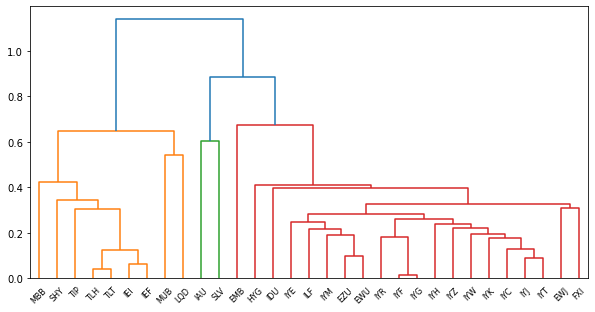

In [71]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
meta = pd.read_csv('etfs_comprehensive.csv', index_col=0)

L = V @ S
distance = pdist(L, metric='cosine')

fig, ax = plt.subplots(figsize=(10, 5))
R = dendrogram(
    Z=linkage(distance, method='average'),
    distance_sort=True,
    get_leaves=True,
    ax=ax,
    color_threshold=.7
)
sorted_idx = R['leaves']
ax.set_xticklabels(sample.columns[sorted_idx])
plt.show()

In [72]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(
    affinity='cosine',
    linkage='average',
    distance_threshold=.7,
    n_clusters=None
)
clustering.fit(L)
print(clustering.n_clusters_, 'clusters found')

# Cluster mapping matrix C
clusters = pd.Series(clustering.labels_, index=sample.columns)
cluster_map = pd.DataFrame(0, index=sample.columns, columns=range(clustering.n_clusters_))

for c in cluster_map.columns:
    members = clusters[clusters == c].index
    cluster_map.loc[members, c] = 1

C = cluster_map.values

res = pd.DataFrame(clustering.labels_, index=sample.columns, columns=['cluster'])
res[['name', 'asset', 'region']] = meta.reindex(res.index)
res

3 clusters found


,cluster,name,asset,region
IYM,0,iShares Dow Jones U.S. Basic Materials,Equities,United States
IYK,0,iShares Dow Jones U.S. Consumer Goods,Equities,United States
IYC,0,iShares Dow Jones U.S. Consumer Services,Equities,United States
IYE,0,iShares Dow Jones U.S. Energy,Equities,United States
IYF,0,iShares Dow Jones U.S. Financial Sector,Equities,United States
IYG,0,iShares Dow Jones U.S. Financial Services,Equities,United States
IYH,0,iShares Dow Jones U.S. Healthcare,Equities,United States
IYJ,0,iShares Dow Jones U.S. Industrial,Equities,United States
IYR,0,iShares Dow Jones U.S. Real Estate,Equities,United States
IYW,0,iShares Dow Jones U.S. Technology,Equities,United States


In [78]:
C

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0]], dtype=int64)

#### 2. Defining the weights as inversevol

In [73]:
W = np.linalg.inv(D)
W = np.divide(W, np.trace(W))
w_inv = np.diag(W)
print('ENB (Inverse Vol, base case):', np.round(effective_bets(w_inv.flatten(), S, V, np.diag(D)), 2))

ENB (Inverse Vol, base case): 1.93


#### 3. No constraints case

In [79]:
# QP
c = clustering.n_clusters_
n = V.shape[0]
P = C.T @ W @ D.T @ V @ S.T @ S @ V.T @ D @ W @ C
q = -C.T @ W @ D @ V @ S @ np.ones((n, 1))

x = cp.Variable(c)
prob = cp.Problem(cp.Minimize((1/2) * cp.quad_form(x, P) + q.T @ x))
prob.solve()
theta = np.divide(x.value.flatten(), np.sum(x.value))
print(np.round(theta, 2))
w_star = W @ C @ theta.reshape(-1, 1)
print(w_star.sum())
print('ENB (clustered, no constraints):', np.round(effective_bets(w_star.flatten(), S, V, np.diag(D)), 2))

[ 0.06 -0.71  1.65]
-0.4369036440945188
ENB (clustered, no constraints): 3.35


### 4. Basic constraint: positivity
First we test the non-clustered version to compare

In [75]:
# QP
n = V.shape[0]
P = D.T @ V @ S.T @ S @ V.T @ D
q = - (np.ones((1, n)) @ S @ V.T @ D).T

tic = time.perf_counter()
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize((1/2) * cp.quad_form(x, P) + q.T @ x))
prob.solve()
toc = time.perf_counter()
print(f"QP finished in {(toc - tic):0.6f} seconds")
w = np.divide(x.value.flatten(), np.sum(x.value))
print(np.round(w, 2))
print('ENB (no cluster, unconstrained):', np.round(effective_bets(x.value.flatten(), S, V, np.diag(D)), 2))

QP finished in 0.017335 seconds
[ 0.01 -0.27  0.15  0.   -0.28  0.2   0.07  0.11  0.08 -0.09  0.04 -0.11
  0.05 -0.01  0.06  0.01 -0.1   0.09  0.01 -0.04  0.56  0.8  -0.82 -0.23
  0.28 -0.03  0.11 -0.19  0.09  0.55 -0.08]
ENB (no cluster, unconstrained): 31.0


In [76]:
# QP
n = V.shape[0]
P = D.T @ V @ S.T @ S @ V.T @ D
q = - (np.ones((1, n)) @ S @ V.T @ D).T
G = - np.eye(n)
h = np.zeros(n)

tic = time.perf_counter()
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize((1/2) * cp.quad_form(x, P) + q.T @ x), [G @ x <= h])
prob.solve()
toc = time.perf_counter()
print(f"QP finished in {(toc - tic):0.6f} seconds")
w = np.divide(x.value.flatten(), np.sum(x.value))
print(np.round(w, 2))
print(w.sum())
print('ENB (no cluster, positivity):', np.round(effective_bets(x.value.flatten(), S, V, np.diag(D)), 2))

QP finished in 0.041864 seconds
[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.03 -0.   -0.    0.5  -0.   -0.   -0.
  0.05 -0.    0.    0.    0.    0.41  0.  ]
1.0
ENB (no cluster, positivity): 3.03


Now the clustered version

[ 0.    1.46 -0.  ]
1.0
ENB (cluster, positivity): 1.68


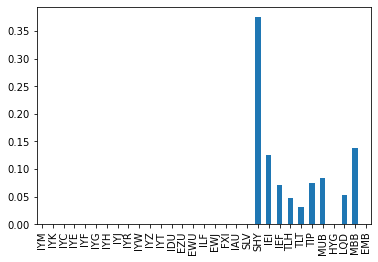

In [77]:
c = clustering.n_clusters_
n = V.shape[0]
P = C.T @ W @ D.T @ V @ S.T @ S @ V.T @ D @ W @ C
q = -C.T @ W @ D @ V @ S @ np.ones((n, 1))

G = - np.eye(c)  # TODO: how can I pass the constraints at the asset level (w), given that I am choosing theta?
h = np.zeros(c)
A = np.ones((1, n)) @ W @ C
b = np.array(1)

x = cp.Variable(c)
prob = cp.Problem(cp.Minimize((1/2) * cp.quad_form(x, P) + q.T @ x), [G @ x <= h, A @ x == b])
prob.solve()
theta = x.value
print(np.round(x.value, 2))
w_star = W @ C @ x.value.reshape(-1, 1)
print(w_star.sum())

print('ENB (cluster, positivity):', np.round(effective_bets(w_star.flatten(), S, V, np.diag(D)), 2))

pd.Series(w_star.flatten(), index=sample.columns).plot.bar()
plt.show()

In [67]:
c = clustering.n_clusters_
n = V.shape[0]
P = C.T @ V @ S.T @ S @ V.T @ C
q = -C.T @ V @ S @ np.ones((n, 1))

G = - np.eye(c)  # TODO: how can I pass the constraints at the asset level (w), given that I am choosing theta?
h = np.zeros(c)
A = np.ones((1, n)) @ D @ C
b = np.array(np.trace(D))

x = cp.Variable(c)
prob = cp.Problem(cp.Minimize((1/2) * cp.quad_form(x, P) + q.T @ x), [G @ x <= h, A @ x == b])
prob.solve()
theta = x.value
print(np.round(x.value, 2))
w_star = np.linalg.inv(W) @ C @ x.value.reshape(-1, 1)
print(w_star.sum())
print('ENB (no constraints):', np.round(effective_bets(w_star.flatten(), S, V, np.diag(D)), 2))

[0.45 0.43 5.61]
1888.0611172625436
ENB (no constraints): 3.29


In [20]:
w_star.round(2)

array([[ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [-0.  ],
       [-0.  ],
       [ 5.69],
       [17.04],
       [30.07],
       [44.52],
       [67.97],
       [28.42],
       [25.26],
       [ 0.  ],
       [40.19],
       [15.54],
       [ 0.  ]])

In [21]:
pd.DataFrame(W @ C).sum()

0    0.295581
1    0.684741
2    0.019677
dtype: float64

In [22]:
np.ones((1, n)) @ W @ C

array([[0.2955813 , 0.6847414 , 0.01967729]])

In [41]:
wx = np.arange(start=0, stop=2.01, step=.01)

w_collect = []
for i in wx:
    for j in wx:
        for k in wx:
            w_collect += [np.array([i, j, k])]

wtest = pd.DataFrame(w_collect)

<AxesSubplot:>

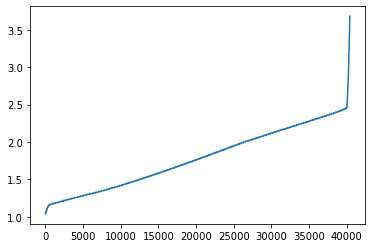

In [38]:
res = pd.Series(index=wtest.index, dtype=float)
for w_i in wtest.index:
    theta = wtest.loc[w_i].values
    w_star = W @ C @ theta.reshape(-1, 1)
    res[w_i] = np.round(effective_bets(w_star.flatten(), S, V, np.diag(D)), 2)

res.sort_values().reset_index(drop=True).plot()

In [39]:
res.sort_values().tail()

1415    3.67
1214    3.67
1414    3.67
1212    3.68
1213    3.68
dtype: float64

[0.06 0.06 0.88]
ENB (no constraints): 3.68


<AxesSubplot:>

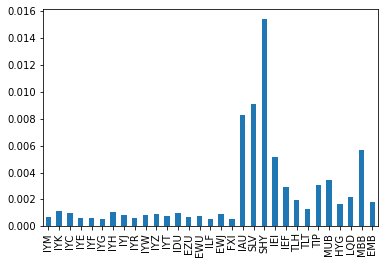

In [40]:
sol = wtest.loc[res.idxmax()].values
print(np.round(sol, 2))
w_star = W @ C @ sol.reshape(-1, 1)
print('ENB (no constraints):', np.round(effective_bets(w_star.flatten(), S, V, np.diag(D)), 2))
pd.Series(w_star.squeeze(), index=sample.columns).plot.bar()